# A tutorial on obtaining accurate speech-to-text alignment for long audio and noisy text

This tutorial consists of two parts. 
- The first part corresponds to the paper *Less Peaky And More Accurate CTC Forced Alignment by Label Priors* published in ICASSP 2024. We will desmonstrate how to obtain more accurate speech-to-text alignment compared to a standard CTC model.
- In the second part, we will provide a robust pytorch-based speech-to-text alignment library to align long audio and noisy text. We will replicate the data preparation step for preparing the [Librispeech corpus](https://www.openslr.org/12). For example, aligning the whole book, [Walden by Henry David Thoreau](https://www.gutenberg.org/cache/epub/205/pg205-images.html) (of 115K words), with its [audiobook chapter](https://librivox.org/walden-by-henry-david-thoreau/) (of 30 minutes in this demo, or even longer) in the [LibriVox project](https://librivox.org/).

20240417: This tutorial is still under development. This is the github repository: [https://github.com/huangruizhe/audio/tree/aligner_label_priors/examples/asr/librispeech_alignment](https://github.com/huangruizhe/audio/tree/aligner_label_priors/examples/asr/librispeech_alignment). 

If you have any questions, please feel free to contact me (huangruizhe09@gmail.com)

## Preparation

In [1]:
# Check python and pytorch's version
!python --version

# import necessary libraries
import torch
import torchaudio

print(f"PyTorch: {torch.__version__}")
print(f"TorchAudio: {torchaudio.__version__}")
print(f"CUDA: {torch.version.cuda}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import IPython
import sys
from tqdm import tqdm

Python 3.10.12


PyTorch: 2.0.1
TorchAudio: 2.2.0a0+0e6ffd5
CUDA: 11.7
cuda


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

For weighted finite state transducer (WFST), our library depends on [k2](https://github.com/k2-fsa/k2/), a pytorch-based WFST library.

In [ ]:
# This will take approximately 1~2 minutes

# k2 (cpu)
# pip install k2==1.24.4.dev20240223+cpu.torch2.2.1 -f https://k2-fsa.github.io/k2/cpu.html
# k2 (gpu)
!pip install k2==1.24.4.dev20240301+cuda12.1.torch2.2.1 -f https://k2-fsa.github.io/k2/cuda.html
!pip install cmudict g2p_en
!pip install git+https://github.com/huangruizhe/lis.git

In [3]:
# ![ ! -d "audio" ] && git clone -b aligner_label_priors https://github.com/huangruizhe/audio.git
# sys.path.append("audio/examples/asr/librispeech_alignment")

sys.path.append("/exp/rhuang/meta/audio_latest/examples/asr/librispeech_alignment")

## Part 1: obtaining more accurate CTC alignment by label priors

### 1.1 Alignment with standard CTC model

#### 1.1.1 Training

The standard CTC model can be trained with the following command. As in the paper, the acoustic model is a TDNN-FFN model of 5M parameters. The frame rate is 0.02 seconds.
```
cd audio/examples/asr/librispeech_alignment/
exp_dir="experiments/ctc_tdnndnn_k2_0.0"

python train.py \
--exp-dir $exp_dir \   
--librispeech-path <path-to-librispeech> \
--global-stats-path ./global_stats.json \
--epochs 10 \
--nodes 1 \
--gpus 4
```

This will train a model in 10 epochs, with train/validation loss going from 3053/2394 down to 1990/1549.

#### 1.1.2 Decoding

The CTC model can be decoded with the following command. Note, the main purpose of the model is not for speech recognition. We just decode it with greedy algorithm as a sanity check. The character error rates (CER) on Librispeech are 4.98%/5.61% on test-clean and test-other.

```
python eval.py \
--checkpoint-path $exp_dir/checkpoints/epoch=9-step=65369.ckpt \
--librispeech-path <path-to-librispeech> \
--global-stats-path ./global_stats.json  \
--use-cuda
```

In [6]:
!exp_dir="/exp/rhuang/meta/audio_latest/examples/asr/librispeech_alignment/experiments/ctc_tdnndnn_k2_0.6"; python ../eval.py --checkpoint-path $exp_dir/checkpoints/epoch=9-step=65369.ckpt   --librispeech-path /exp/rhuang/librispeech/download2   --global-stats-path ../global_stats.json   --use-cuda

Processed elem 0; CER: 0.03571428571428571
Processed elem 100; CER: 0.04276037256562235
Processed elem 200; CER: 0.043059125964010285
Processed elem 300; CER: 0.04241228688178104
Processed elem 400; CER: 0.044804469273743014
Processed elem 500; CER: 0.04738933030646992
Processed elem 600; CER: 0.04619523443504996
Processed elem 700; CER: 0.047683831031902595
Processed elem 800; CER: 0.04916825240930575
Processed elem 900; CER: 0.04977900552486188
Processed elem 1000; CER: 0.048406596063639444
Processed elem 1100; CER: 0.046886977259177245
Processed elem 1200; CER: 0.04756247277335551
Processed elem 1300; CER: 0.04819053968959514
Processed elem 1400; CER: 0.048368720870015536
Processed elem 1500; CER: 0.048455305549278495
Processed elem 1600; CER: 0.04795854177275859
Processed elem 1700; CER: 0.04846568082742115
Processed elem 1800; CER: 0.04919958476752445
Processed elem 1900; CER: 0.049972398201940015
Processed elem 2000; CER: 0.050266278135048234
Processed elem 2100; CER: 0.050490243

In [7]:
!exp_dir="/exp/rhuang/meta/audio_latest/examples/asr/librispeech_alignment/experiments/ctc_tdnndnn_k2_0.6"; python ../eval.py --checkpoint-path $exp_dir/checkpoints/epoch=9-step=65369.ckpt   --librispeech-path /exp/rhuang/librispeech/download2   --global-stats-path ../global_stats.json   --use-cuda

Processed elem 0; CER: 0.03125
Processed elem 100; CER: 0.06344221105527638
Processed elem 200; CER: 0.06668878566688785
Processed elem 300; CER: 0.060587761674718195
Processed elem 400; CER: 0.06153137946908087
Processed elem 500; CER: 0.06134443492102363
Processed elem 600; CER: 0.05866848887153456
Processed elem 700; CER: 0.05608897423587774
Processed elem 800; CER: 0.05872864579514627
Processed elem 900; CER: 0.05821541642437165
Processed elem 1000; CER: 0.05713470319634703
Processed elem 1100; CER: 0.05746946445349201
Processed elem 1200; CER: 0.05805017158876698
Processed elem 1300; CER: 0.057332980786180154
Processed elem 1400; CER: 0.057244422652610934
Processed elem 1500; CER: 0.05665006038647343
Processed elem 1600; CER: 0.05695887291874199
Processed elem 1700; CER: 0.056524773203070484
Processed elem 1800; CER: 0.0560134357602712
Processed elem 1900; CER: 0.05692128035452286
Processed elem 2000; CER: 0.05621891945045374
Processed elem 2100; CER: 0.05610895980771799
Processed

#### 1.1.3 Alignment

In [4]:
SPEECH_FILE = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
transcript = "i had that curiosity beside me at this moment"

In [54]:
IPython.display.Audio(SPEECH_FILE)

In [5]:
from alignment.tokenizer import EnglishPhonemeTokenizer
from transforms import TestTransform
from lightning import AcousticModelModule
import IPython
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = [16.0, 3.0]

/home/hltcoe/rhuang/mambaforge/envs/aligner5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare data for the acoustic model:

In [6]:
tokenizer = EnglishPhonemeTokenizer()
global_stats_path = "../global_stats.json"
# global_stats_path = "audio/examples/asr/librispeech_alignment/global_stats.json"
test_transform = TestTransform(global_stats_path=global_stats_path, tokenizer=tokenizer)

waveform, sample_rate = torchaudio.load(SPEECH_FILE)
speaker_id, chapter_id, utterance_id = 0, 0, 0

sample = (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id)
batch, samples = test_transform(sample)

Load the acoustic model:

In [33]:
# checkpoint_path = "audio/examples/asr/librispeech_alignment/checkpoints/ctc_tdnndnn_k2_0.0/epoch=9-step=65369.ckpt"
checkpoint_path = "checkpoints/ctc_tdnndnn_k2_0.0/epoch=9-step=65369.ckpt"
model_standard = AcousticModelModule.load_from_checkpoint(checkpoint_path, tokenizer=tokenizer).eval()

Get the forced alignment:

In [34]:
def unflatten(list_, lengths):
    assert len(list_) == sum(lengths)
    i = 0
    ret = []
    for l in lengths:
        ret.append(list_[i : i + l])
        i += l
    return ret

tokenized_transcript = tokenizer.encode_flatten(transcript, out_type=int)
emission = model_standard.forward(batch)
aligned_tokens, alignment_scores = model_standard.align(batch, tokenized_transcript)
token_spans = torchaudio.functional.merge_tokens(aligned_tokens, alignment_scores)
word_spans = unflatten(token_spans, [len(tokenizer.encode_flatten(word)) for word in transcript.split()])

Visualize the alignment:

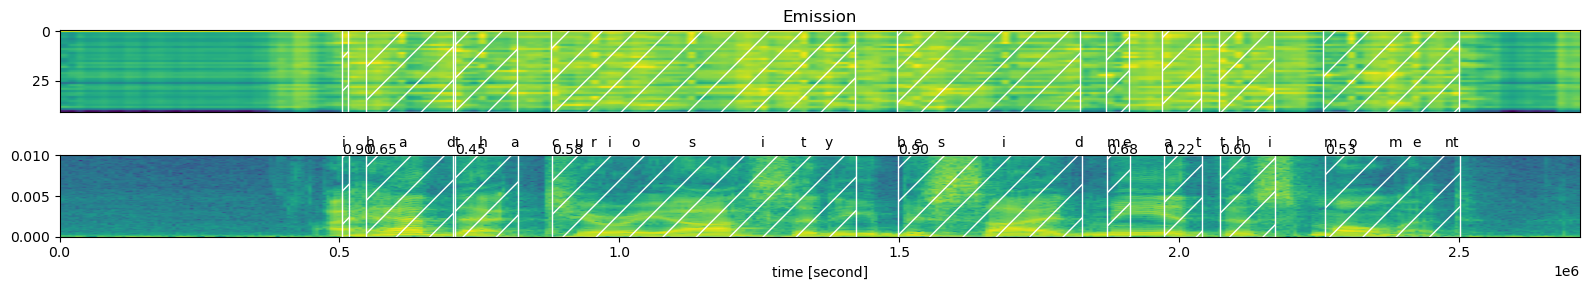

In [35]:
# Compute average score weighted by the span length
def _score(spans):
    return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)


def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=0.02):
    ratio = waveform.size(1) / emission.size(1) / sample_rate

    fig, axes = plt.subplots(2, 1)
    axes[0].imshow(emission[0].detach().cpu().T, aspect="auto")
    axes[0].set_title("Emission")
    axes[0].set_xticks([])

    axes[1].specgram(waveform[0], Fs=sample_rate)
    for t_spans, chars in zip(token_spans, transcript):
        t0, t1 = t_spans[0].start + 0.1, t_spans[-1].end - 0.1
        axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")
        axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")
        axes[1].annotate(f"{_score(t_spans):.2f}", (ratio * t0, sample_rate * 0.51), annotation_clip=False)

        for span, char in zip(t_spans, chars):
            t0 = span.start * ratio
            axes[1].annotate(char, (t0, sample_rate * 0.55), annotation_clip=False)

    axes[1].set_xlabel("time [second]")
    axes[1].set_xlim([0, None])
    fig.tight_layout()


plot_alignments(waveform, word_spans, emission, transcript.split())

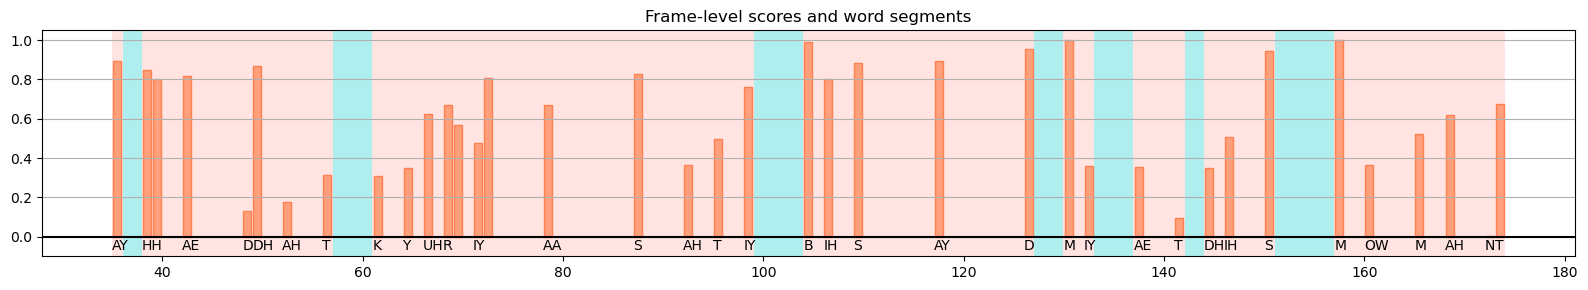

In [14]:
def plot_scores(word_spans, scores):
    fig, ax = plt.subplots()
    span_xs, span_hs = [], []
    ax.axvspan(word_spans[0][0].start - 0.05, word_spans[-1][-1].end + 0.05, facecolor="paleturquoise", edgecolor="none", zorder=-1)
    for t_span in word_spans:
        for span in t_span:
            for t in range(span.start, span.end):
                span_xs.append(t + 0.5)
                span_hs.append(scores[t].item())
            ax.annotate(tokenizer.id2token[span.token], (span.start, -0.07))
        ax.axvspan(t_span[0].start - 0.05, t_span[-1].end + 0.05, facecolor="mistyrose", edgecolor="none", zorder=-1)
    ax.bar(span_xs, span_hs, color="lightsalmon", edgecolor="coral")
    ax.set_title("Frame-level scores and word segments")
    ax.set_ylim(-0.1, None)
    ax.grid(True, axis="y")
    ax.axhline(0, color="black")
    fig.tight_layout()


plot_scores(word_spans, alignment_scores)

In [36]:
audacity_labels_1 = "\n".join([f"{t_span[0].start * 0.02}\t{t_span[-1].end * 0.02}\t{w}" for t_span, w in zip(word_spans, transcript.split())])

### 1.2 Alignment with CTC model with label priors

The CTC model with label priors can be trained with the following command. The only difference is that we added the "--alpha 0.6" option.
```
cd audio/examples/asr/librispeech_alignment/
exp_dir="experiments/ctc_tdnndnn_k2_0.6"

python train.py \
--exp-dir $exp_dir \   
--librispeech-path <path-to-librispeech> \
--global-stats-path ./global_stats.json \
--epochs 10 \
--nodes 1 \
--gpus 4 \
--alpha 0.6
```

This will train a model in 10 epochs, with the label priors for the blank token converging from 0.79 to 0.28.

The model can be decoded with the same command as above. The CER is 4.98%/5.61% on test-clean and test-other.

In [29]:
# checkpoint_path = "audio/examples/asr/librispeech_alignment/checkpoints/ctc_tdnndnn_k2_0.6/epoch=9-step=65369.ckpt"
checkpoint_path = "checkpoints/ctc_tdnndnn_k2_0.6/epoch=9-step=65369.ckpt"
model_with_priors = AcousticModelModule.load_from_checkpoint(checkpoint_path, tokenizer=tokenizer).eval()

In [37]:
tokenized_transcript = tokenizer.encode_flatten(transcript, out_type=int)
emission = model_with_priors.forward(batch)
aligned_tokens, alignment_scores = model_with_priors.align(batch, tokenized_transcript)
token_spans = torchaudio.functional.merge_tokens(aligned_tokens, alignment_scores)
word_spans = unflatten(token_spans, [len(tokenizer.encode_flatten(word)) for word in transcript.split()])

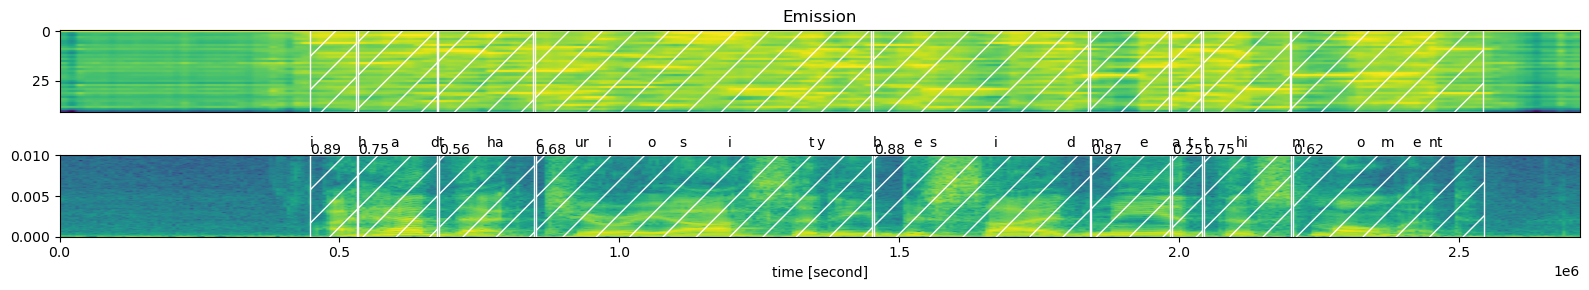

In [18]:
plot_alignments(waveform, word_spans, emission, transcript.split())

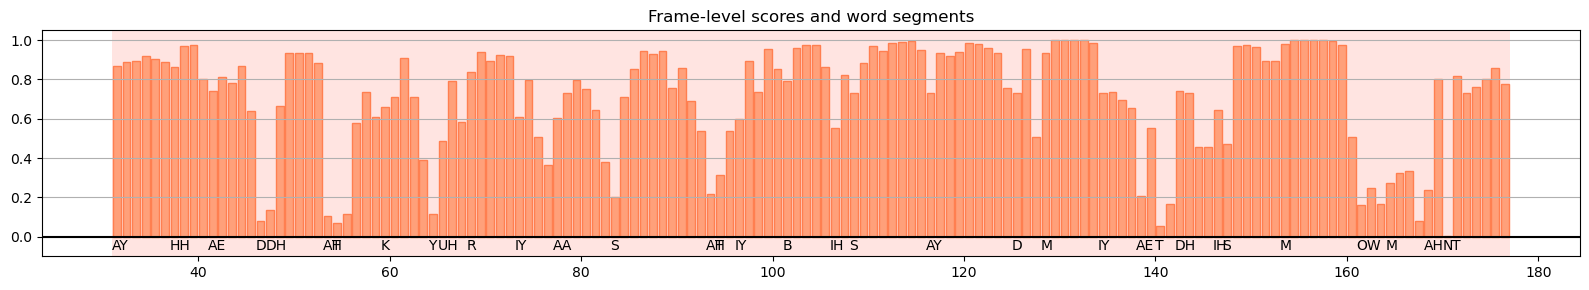

In [19]:
plot_scores(word_spans, alignment_scores)

In [38]:
audacity_labels_2 = "\n".join([f"{t_span[0].start * 0.02}\t{t_span[-1].end * 0.02}\t{w}" for t_span, w in zip(word_spans, transcript.split())])

As we can see from the visualization above, the CTC model trained with label priors can produce less peaky posteriors compared to a standard CTC model. We can save the audacity labels and import them to [Audacity](https://manual.audacityteam.org/man/importing_and_exporting_labels.html). We can see the alignments with label priors are more accurate than the standard one.

In [39]:
open('audacity_labels_1.txt', 'w').write(audacity_labels_1)
open('audacity_labels_2.txt', 'w').write(audacity_labels_2)

191

### 1.3 Fine-tuning CTC model with label priors

In [43]:
# To be added. Basically, we will replicate the results in the paper in this part

## Part 2: obtaining robust alignment for long audio and noisy text

In part 1, we performed forced alignment at the utterance level. In practice, we don't usually have a small segment (e.g., 10 seconds) of audio and its corresponding exact, verbatim transcription as in a laboratory setting (e.g. [LIBRISPEECH](https://www.openslr.org/12) corpus). Instead, the audios come in long form (e.g., a whole mp3 recording of speech for an hour). The transcription for the whole recording can by noisy and non-verbatim, which may not exactly match what's been spoken in the recording. In particular, in order to use the raw speech data for machine learning, we usually need to prepare a corpus of segmented audios. In some applications, we still hope to align the long audio and text data as much as possible. In this tutorial, we will provide a python library to support such use cases.

Here, we are facing two challenges:
- **The audio is long**, which may not be suitable to be handled as a whole due to, e.g., limited CPU/GPU memory.
- **The transcript is noisy**. It can be a partial transcript with some missing words. It may have significant errors. It may also contain extra contents that's not spoken in the audio (e.g., the corresponding audio is corrupted). It can be a combination of all cases. Thus, the conventional, basic forced alignment algorithm could provide very bad alignment results, as it assumes the audio and text match exactly.

There are a few existing solutions:
- [Kaldi](https://ieeexplore.ieee.org/document/8268956), [Gentle](https://github.com/lowerquality/gentle) and [this work](https://ieeexplore.ieee.org/document/7404861) employ a weighted finite state transducer (WFST) framework to model the noisy texts. 
- [WhisperX](https://github.com/m-bain/whisperX) uses attention mechanism to propose rough time stamps for uniformly segmented audio. Then, it performs phone-level or word-level forced alignment with an external aligner.
- [MMS](https://arxiv.org/abs/2305.13516) uses a special `<star>` token to handle missing words in the transcript.
- [SailAlign](https://www.semanticscholar.org/paper/SailAlign%3A-Robust-long-speech-text-alignment-Katsamanis-Georgiou/0b7f86429641b188cc62ec32eee590e8795a3d02) iteratively identifies reliable regions and then narrows down to align the remaining unaligned regions.

This tutorial is based on WFST and thus falls in the first category. Our implementation is based on PyTorch. Any CTC model in PyTorch can be equipped with our library to become a robust aligner. This makes our aligner distinguish from existing ones.

### 2.1 Preparation

In [7]:
from alignment.torchaudio_k2_aligner import (
    uniform_segmentation_with_overlap,
    align_segments,
    concat_alignments,
    get_final_word_alignment,
    align,
    get_audacity_labels,
    get_gentle_visualization,
)
from alignment.tokenizer import EnglishCharTokenizer
from alignment.factor_transducer import make_factor_transducer_word_level_index_with_skip

We will use a pre-trained Wav2Vec2 model, [torchaudio.pipelines.MMS_FA](https://pytorch.org/audio/main/generated/torchaudio.pipelines.MMS_FA.html#torchaudio.pipelines.MMS_FA), as the acoustic model.

In [6]:
bundle = torchaudio.pipelines.MMS_FA
model = bundle.get_model(with_star=False).to(device)

In [7]:
LABELS = bundle.get_labels(star="*")
DICTIONARY = bundle.get_dict(star="*")

print(LABELS)

tokenizer = EnglishCharTokenizer(
    token2id=DICTIONARY,
    blk_token="-",
    unk_token="*",
)

('-', 'a', 'i', 'e', 'n', 'o', 'u', 't', 's', 'r', 'm', 'k', 'l', 'd', 'g', 'h', 'y', 'b', 'p', 'w', 'c', 'v', 'j', 'z', 'f', "'", 'q', 'x', '*')


### 2.2 Prepare long audio and noisy text

We will demonstrate aligning the whole book, [Walden by Henry David Thoreau](https://www.gutenberg.org/cache/epub/205/pg205-images.html) (of 115K words), with its audiobook chapter (of 30 minutes) in the [LibriVox project](https://librivox.org/walden-by-henry-david-thoreau/).

In [8]:
# Download the whole book
import requests
from bs4 import BeautifulSoup

url = "https://www.gutenberg.org/cache/epub/205/pg205-images.html"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

text = soup.get_text()
text = text.replace("\r\n", "\n")

In [9]:
# Download a chapter of the audio book
# !wget https://ia800707.us.archive.org/20/items/walden_librivox/walden_c07.mp3

SPEECH_FILE = "walden_c07.mp3"

In [ ]:
# Play the long audio
IPython.display.Audio(SPEECH_FILE)

In [ ]:
# Preview the transcript
print(text[:1000])

In [ ]:
# Preview the transcript relevant to the audio

# In this running example, the whole audio corresponds to 
# text[271616: 293529]
# or
# text.split()[49489: 53362]

print(text[271400: 271400+1000])

As we can see above, the audio contains a header "This is a LibriVox recording ..." which is not transcribed. On the other hand, as we have downloaded the whole book, it contains a lot of extra text that's not spoken in the audio. Obviously, the standard forced alignment algorithm will not work in this case.

In [10]:
# We tokenize the text into the labels of the acoustic model's output
text_tokenized = tokenizer.encode(tokenizer.text_normalize(text))

print(f"There are {len(text_tokenized)} words in the text")

# Preview the tokenization results. This corresponds to the beginning of the audio
print(tokenizer.decode(text_tokenized)[49489: 49489+15])

There are 118840 words in the text
[['t', 'h', 'e'], ['b', 'e', 'a', 'n', 'f', 'i', 'e', 'l', 'd'], ['m', 'e', 'a', 'n', 'w', 'h', 'i', 'l', 'e'], ['m', 'y'], ['b', 'e', 'a', 'n', 's'], ['t', 'h', 'e'], ['l', 'e', 'n', 'g', 't', 'h'], ['o', 'f'], ['w', 'h', 'o', 's', 'e'], ['r', 'o', 'w', 's'], ['a', 'd', 'd', 'e', 'd'], ['t', 'o', 'g', 'e', 't', 'h', 'e', 'r'], ['w', 'a', 's'], ['s', 'e', 'v', 'e', 'n'], ['m', 'i', 'l', 'e', 's']]


### 2.3 Use WFST to represent the text

#### 2.3.1 WFST basics

#### 2.3.2 CTC graph, factor transducer and the variants

Now, we will represent the whole book of over 100K words into one single WFST decoding graph that allows occasional insertion/deletioin/substitution errors. We set `skip_penalty=-0.5` and `return_penalty=-18.0`.

In [11]:
decoding_graph, word_index_sym_tab, token_sym_tab = \
    make_factor_transducer_word_level_index_with_skip(
        text_tokenized, 
        blank_penalty=0, 
        skip_penalty=-0.5, 
        return_penalty=-18.0
    )
decoding_graph = decoding_graph.to(device)

print(f"There are {decoding_graph.shape[0]} nodes and {decoding_graph.num_arcs} arcs in the decoding graph for the text of {len(text_tokenized)} words.")
print(f"The decoding graph is on device: {decoding_graph.device}")

There are 1028287 nodes and 3544014 arcs in the decoding graph for the text of 118840 words.
The decoding graph is on device: cuda:0


### 2.4 Handle long audio

We hope to feed the audio into the neural network to get the frame-wise posteriors (i.e., the emission matrix) over the label vocabulary. However, the audio book chapter is of about 30 minutes. This is too long to feed into the acoustic model all at once. 

A common practice is to segment the long audio into small overlapping segments. The segments are processed independently and the results are concatenated appropriately to make the final alignment result. Here, as the Wav2Vec2 pretrained model that we use is taking a raw wave form as input, so we will segment the original audio into 15-second segments. In practice, we can also segment the feature vector (e.g., Fbanks) to feed into the acoustic model.

The library that we provide in this tutorial provides functions for appropriate segmentation and concatenation.

Now, let's use the library to segment the 30-minute audio into 15-second segments, with an overlap of 2 seconds between neighboring segments.

In [12]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
resample_rate = 16000  # this is the sample rate of the Wav2Vec2 model
waveform = torchaudio.functional.resample(waveform, sample_rate, resample_rate)
sample_rate = resample_rate
print(waveform.shape, sample_rate)

torch.Size([1, 29075748]) 16000


In [13]:
if waveform.dim() == 2:
    waveform.unsqueeze_(-1)
segment_size = sample_rate * 15 + 128  # 15 seconds; use extra 128 waveform samples to make sure we have 750 frames for each full-sized segment
overlap = sample_rate * 2 + 128        # 2 seconds
shortest_segment_size = sample_rate * 0.2  # if the last segment has less than 3200 samples (0.2 seconds), it will be discarded

waveform_segmented, segment_lengths, segment_offsets = uniform_segmentation_with_overlap(
    waveform,
    segment_size, 
    overlap, 
    shortest_segment_size=shortest_segment_size
)
waveform_segmented = waveform_segmented.squeeze()
print(waveform_segmented.shape, segment_lengths.shape, segment_offsets.shape)

torch.Size([140, 240128]) torch.Size([140]) torch.Size([140])


We can listen to a segment to make sure the segmentation pipeline runs correctly.

In [ ]:
IPython.display.Audio(waveform_segmented[0], rate=sample_rate)

### 2.5 Obtain alignment

Now, we will feed the short segments to the neural network based acoustic model. We do this in batches. For each segment, the acoustic model produces frame-wise classification `batch_emissions` over its label vocabulary. This is then combined with the WFST `decoding_graph`, which is shared by all segments, to produce the best alignment path for each segment. If the `decoding_graph` is a linear WFST, which means there is no insertion/deletion/substitution errors in the transcript, this is equivalent to the conventional forced alignment as provided by this [TorchAudio API](https://pytorch.org/audio/main/tutorials/ctc_forced_alignment_api_tutorial.html).

There something to note for the `decoding_graph`. When we combine it with the neural network output, its "input label" should match the network's label vocabulary. However, it is our decision to define decoding graph's "output labels", which basically ask this question: what do we align the audio to? Here are two examples of design choices:

- The output labels are word labels or phoneme labels, as in most WFST-based alignment solutions (e.g., in [Gentle](https://github.com/lowerquality/gentle/blob/master/gentle/diff_align.py#L16)). In this case, the alignment paths consist of the word-level or phoneme-level transcripts predicted by the model.

- The output labels are the **word indices** in the transcript, instead of word labels. There are two benefits: (1) we can obtain the word labels easily from the word indices; (2) with word indices, we are able to preserve the ordering of words in the transcript, even though the alignment paths may contain words in the order different from the original transcript. As we will see later, this word ordering information enables efficient and effective heuristics for post-processing.

In [14]:
if device == torch.device("cpu"):
    batch_size = 2
else:
    batch_size = 32

output_frames_offset = segment_offsets // (sample_rate * 0.02)

alignment_results = list()
for i in tqdm(range(0, waveform_segmented.size(0), batch_size)):
    batch_waveform_segmented = waveform_segmented[i: i+batch_size].to(device)
    batch_segment_lengths = segment_lengths[i: i+batch_size]
    batch_output_frames_offset = output_frames_offset[i: i+batch_size]

    with torch.inference_mode():
        # Checkout the API of the forward function here: https://github.com/pytorch/audio/blob/main/src/torchaudio/pipelines/_wav2vec2/utils.py#L34
        batch_emissions, batch_emissions_lengths = model(batch_waveform_segmented.to(device), batch_segment_lengths.to(device))
    
    # Attach the star dimension manually, see torchaudio issue #3772
    star_dim = torch.empty((batch_emissions.size(0), batch_emissions.size(1), 1), device=batch_emissions.device, dtype=batch_emissions.dtype)
    star_dim[:] = -5.0
    batch_emissions = torch.cat((batch_emissions, star_dim), 2)

    # `token_ids` and `timestamps` will each be a list of lists.
    # Each sublist corresponds to a segment in the batch.
    batch_results = align_segments(
        batch_emissions,
        decoding_graph,
        batch_emissions_lengths,
    )

    # The interpretation of `token.token_id` depends on the decoding graph.
    # Here, in this tutorial, `token.token_id` is the key to the `word_index_sym_tab``
    # and `token_sym_tab` dictionaries.
    for aligned_tokens, offset in zip(batch_results, batch_output_frames_offset):
        for token in aligned_tokens:
            token.timestamp += offset  # This will become the absolute frame timestamp in the whole audio
            if token.token_id == tokenizer.blk_id:
                continue
            if token.token_id in word_index_sym_tab:
                token.attr["wid"] = word_index_sym_tab[token.token_id]
            if token.token_id in token_sym_tab:
                token.attr["tk"] = token_sym_tab[token.token_id]            

    alignment_results.extend(batch_results)

    # It will be too slow to do inference on CPU. 
    # As it's only for the demonstration purpose, so we will break the loop here.
    # We can still see some partial alignment results.
    if device == torch.device("cpu"):
        break

100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


We've got the alignment results for all 140 15-second segments in less than a minute, thanks to GPU acceleration.

In [15]:
len(alignment_results)

140

Now we are going to concatenate the alignment results appropriately. We need to take care of two things: (1) the mis-aligned results, (2) the overlapping parts. The common algorithm for this concatenation step is through [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) (e.g., in [Gentle](https://github.com/lowerquality/gentle/blob/master/gentle/diff_align.py#L16)), which aligns the forced-aligned transcript with the ground-truth transcript. As we have word indices instead of word labels, we will do this a bit differently. Given the alignment results for all segments, we will find the [longest increasing subsequence (LIS)](https://en.wikipedia.org/wiki/Longest_increasing_subsequence) in the word indices. This can be done in $O(NlogN)$ time complexity and $O(N)$ space complexity, instead of $O(N^2)$ by Levenshtein distance, where $N$ is the total length of the segment-wise alignment results. This can be useful especially when $N$ is large for long audios. The python implementation of efficient LIS algorithm can be found in [this repository](https://github.com/huangruizhe/lis).

Moreover, with word indices, we are able to develop heuristics to remove outliers in the alignment results. This has been all implemented in our alignment library. E.g., by calling the `concat_alignments` function below.

In [16]:
# TODO: 
# The beginning and ending of the audio is hard to be aligned to the book.
# We might need to use VAD or something to handle it. Or predefine the start/end of the audio and text.
# Ignored them for now cos we just use the alignment for ASR training.

# `resolved_alignment_results` is a list of `AlignedToken`
# `unaligned_text_indices` is a list of (start_word_index, end_word_index)
#    which corresponds to "holes" in the long text that are not aligned
resolved_alignment_results, unaligned_text_indices = concat_alignments(
    alignment_results, 
    neighborhood_size=5,
)

len(resolved_alignment_results), len(unaligned_text_indices)

# We can check the results in `resolved_alignment_results`:
# text_splitted = text.split()
# [text_splitted[tk.attr['wid']] if 'wid' in tk.attr else tokenizer.id2token[tk.attr['tk']] for tk in resolved_alignment_results[-40:-1]]

(16163, 41)

Our final word-level alignment results can be obtained by the following, where `word_alignment` is a dictionary from word indices in `text` to an `AlignedWord` object.

In [17]:
# `word_alignment` is a dict of word index in the long text => AlignedWord object
word_alignment = get_final_word_alignment(resolved_alignment_results, text, tokenizer)

Finally, let's preview the alignment results:

In [18]:
list(word_alignment.items())[:10]

[(49491,
  AlignedWord(word='Meanwhile', start_time=tensor(1256.), end_time=None, phones=[AlignedToken(token_id='m', timestamp=tensor(1256.), attr=None), AlignedToken(token_id='e', timestamp=tensor(1258.), attr=None), AlignedToken(token_id='a', timestamp=tensor(1261.), attr=None), AlignedToken(token_id='n', timestamp=tensor(1263.), attr=None), AlignedToken(token_id='w', timestamp=tensor(1266.), attr=None), AlignedToken(token_id='h', timestamp=tensor(1267.), attr=None), AlignedToken(token_id='h', timestamp=tensor(1268.), attr=None), AlignedToken(token_id='i', timestamp=tensor(1274.), attr=None), AlignedToken(token_id='l', timestamp=tensor(1278.), attr=None), AlignedToken(token_id='e', timestamp=tensor(1280.), attr=None)])),
 (49492,
  AlignedWord(word='my', start_time=tensor(1283.), end_time=None, phones=[AlignedToken(token_id='m', timestamp=tensor(1283.), attr=None), AlignedToken(token_id='y', timestamp=tensor(1296.), attr=None)])),
 (49493,
  AlignedWord(word='beans,', start_time=tens

In [19]:
list(word_alignment.items())[-10:]

[(53352,
  AlignedWord(word='mind', start_time=tensor(90157.), end_time=None, phones=[AlignedToken(token_id='m', timestamp=tensor(90157.), attr=None), AlignedToken(token_id='i', timestamp=tensor(90168.), attr=None), AlignedToken(token_id='n', timestamp=tensor(90171.), attr=None), AlignedToken(token_id='n', timestamp=tensor(90172.), attr=None), AlignedToken(token_id='d', timestamp=tensor(90175.), attr=None)])),
 (53353,
  AlignedWord(word='not', start_time=tensor(90212.), end_time=None, phones=[AlignedToken(token_id='n', timestamp=tensor(90212.), attr=None)])),
 (53354,
  AlignedWord(word='only', start_time=tensor(90224.), end_time=None, phones=[AlignedToken(token_id='o', timestamp=tensor(90224.), attr=None), AlignedToken(token_id='n', timestamp=tensor(90227.), attr=None), AlignedToken(token_id='l', timestamp=tensor(90229.), attr=None), AlignedToken(token_id='l', timestamp=tensor(90230.), attr=None), AlignedToken(token_id='y', timestamp=tensor(90231.), attr=None)])),
 (53355,
  AlignedW

As we can see from above, the alignment results look pretty good! Despite the book being long and noisy (e.g., ), it successfully locates [the chapter](https://www.gutenberg.org/cache/epub/205/pg205-images.html#chap08) from the whole book corresponding to the audio, except the first two words ("The Bean-Field") which are the chapter title. We will do some visualization to verify this results later.

On the other hand, in `unaligned_text_indices`, we can see the parts in the book chapter that are not successfully aligned to the audio:

In [20]:
# The range [s, e] (both inclusive) is a "hole" in the long text that is not aligned
# where s and e are the word indices in the long text
text_splitted = text.split()
print(f"There are {len([None for s, e in unaligned_text_indices if e - s > 0])} holes of size greater than one word, out of {len(unaligned_text_indices)} holes in total.\n")
for s, e in unaligned_text_indices:
    if e - s > 0: # ignore the "holes" of only one word
        print(f"Unaligned text range: [{s}, {e}]")
        print(f"Unaligned text: {text_splitted[s:e+1]}")
        print(f"Time range: {word_alignment[s-1].start_time * 0.02:.2f} ~ {word_alignment[e+1].start_time * 0.02:.2f} seconds")
        print()

There are 18 holes of size greater than one word, out of 41 holes in total.

Unaligned text range: [49633, 49637]
Unaligned text: ['cherish', 'them,', 'I', 'hoe', 'them,']
Time range: 92.88 ~ 97.24 seconds

Unaligned text range: [50262, 50263]
Unaligned text: ['very', 'agricola']
Time range: 364.94 ~ 368.42 seconds

Unaligned text range: [50627, 50633]
Unaligned text: ['I', 'cultivated,', 'and', 'my', 'hoe', 'played', 'the']
Time range: 534.18 ~ 539.00 seconds

Unaligned text range: [50929, 50954]
Unaligned text: ['day', 'of', 'it—like', 'a', 'mote', 'in', 'the', 'eye,', 'or', 'in', 'heaven’s', 'eye,', 'falling', 'from', 'time', 'to', 'time', 'with', 'a', 'swoop', 'and', 'a', 'sound', 'as', 'if', 'the']
Time range: 664.98 ~ 675.66 seconds

Unaligned text range: [51193, 51199]
Unaligned text: ['far.', 'To', 'me,', 'away', 'there', 'in', 'my']
Time range: 794.90 ~ 799.00 seconds

Unaligned text range: [51509, 51512]
Unaligned text: ['my', 'chivalry', 'upon.', 'These']
Time range: 924.86 

### 2.6 Visualization of alignment results

Finally, we can listen to and visually check the alignment results. We will provide two methods, [Audacity](https://www.audacityteam.org/) and [Gentle](http://lowerquality.com/gentle/). 

#### 2.6.1 Audacity

For Audacity, we will provide the label file that can be imported to the software along with the audio file. Follow the instructions [here](https://manual.audacityteam.org/man/importing_and_exporting_labels.html) to import labels.

In [21]:
audacity_labels_str = get_audacity_labels(word_alignment, frame_duration=0.02)

audacity_path = str(SPEECH_FILE)[:-4] + "_audacity.txt"
with open(audacity_path, "w") as fout:
    print(audacity_labels_str, file=fout)

#### 2.6.2 Gentle

Gentle comes with a nice, handly [visualization mechanism](https://github.com/lowerquality/gentle/blob/master/serve.py#L113) based on HTML and JavaScript. The following function will generate the necessary files (the "index.html" file) and instructions for visualization in Gentle.

In [46]:
get_gentle_visualization(word_alignment, tokenizer, frame_duration=0.02, audio_file=SPEECH_FILE, text=text, i_word_start=49489, i_word_end=53362)

Gentle visualization is saved to: /exp/rhuang/meta/audio_latest/examples/asr/librispeech_alignment/alignment/index.html
Usage instrunctions:
- Download both the audio file and the index.html file to the same folder in your local machine;
- Open the index.html file in a browser.


TODO:
- dataclass for alignment results [done]
- inspect the improvement for walden
- phone-level alignment [done]
- gentle [done]
- quasi-gentle in colab
- training recipe: need to start it tonight [done]

In [45]:
import torchaudio_k2_aligner

import importlib
importlib.reload(torchaudio_k2_aligner)

get_gentle_visualization = torchaudio_k2_aligner.get_gentle_visualization